# DataVisiualisation

## Getting the feature vectors

This follows this Notbook closely : https://github.com/ml4a/ml4a-guides/blob/master/notebooks/image-search.ipynb

In [3]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Using TensorFlow backend.


In [4]:
model = VGG16(weights='imagenet', include_top=True)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

We want to use this network to extract meaningful feature vectors. So we use the network as is, but chop off the prediction layer:

In [5]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [6]:
nrows = None
df = pd.read_csv("../data/db.csv",nrows=nrows,na_values="?")
image_path = "images/"

In [7]:
def get_selection(df, size = 1000, column = 'random', criterium = 'random'):
    """ Returns a sample of data rows from a dataframe according to a chosen selection
        
        Arguments:
            df: dataframe to choose the selection from
            size: size of the returned sample
            column: the name of a column
            criterium: the function will return all rows with this entry in the specified column
        
        Return:
            A dataframe consisting of size (or less if not enough hits) rows meeting the criterium
        """
    # created dataframe matching selected criteria
    if column == 'random':
        df_sel = df
    else:
        if criterium == 'random':
            classes = list(set(df[column]))
            class_sel = classes[np.random.choice(len(classes))]
        else: 
            class_sel = criterium
        df_sel = df.loc[df[column] == class_sel]
    
    # create random sample of  requested size
    if len(df_sel)< size:
        print('The requested size was longer than the number of matches in the data frame. '
              +'Output size is {0} instead of {1}.'.format(len(df_sel), size))
        size = len(df_sel)
    idx = np.arange(len(df_sel))
    rand = np.random.choice(idx, size=size, replace=False)
    return df_sel.iloc[rand]

Get a predefined frame. In this case we want to cluster all pictures by Michelangelo.

In [8]:
df_sel = get_selection(df, size = 100, column = 'artistname', criterium = 'pablo picasso')
df_sel.head()

,_id,artistname,genre,image,image_size_data,style,title,year
150345,57727411edc2cb3880cad5da,pablo picasso,genre painting,https://uploads3.wikiart.org/images/pablo-pica...,"[{'sizekb': 17, 'width': 210, 'height': 287, '...",surrealism,maya with boat,1938
150591,57727401edc2cb3880ca62c4,pablo picasso,portrait,https://uploads4.wikiart.org/images/pablo-pica...,"[{'sizekb': 16, 'width': 210, 'height': 279, '...",surrealism,family,1965
150425,5772742eedc2cb3880cafe7e,pablo picasso,portrait,https://uploads3.wikiart.org/images/pablo-pica...,"[{'sizekb': 13, 'width': 210, 'height': 269, '...",expressionism,woman with hat,1943
150411,57727419edc2cb3880cae174,pablo picasso,portrait,https://uploads1.wikiart.org/images/pablo-pica...,"[{'sizekb': 12, 'width': 210, 'height': 260, '...",surrealism,portrait of woman,1942
149832,57727401edc2cb3880ca62a4,pablo picasso,still life,https://uploads3.wikiart.org/images/pablo-pica...,"[{'sizekb': 15, 'width': 210, 'height': 307, '...",expressionism,exotic flowers,1907


In [9]:
def load_image(path, target_size = None):
    img = image.load_img(path, target_size = target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Let's make an example:

shape of x:  (1, 224, 224, 3)
data type:  float32


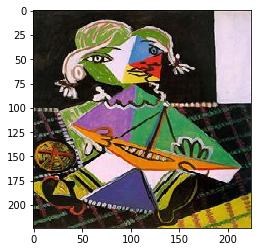

In [10]:
img, x = load_image(image_path + df_sel['_id'].iloc[0] + '.jpg', target_size = model.input_shape[1:3])
print("shape of x: ", x.shape)
print("data type: ", x.dtype)
plt.imshow(img)

(1, 4096)


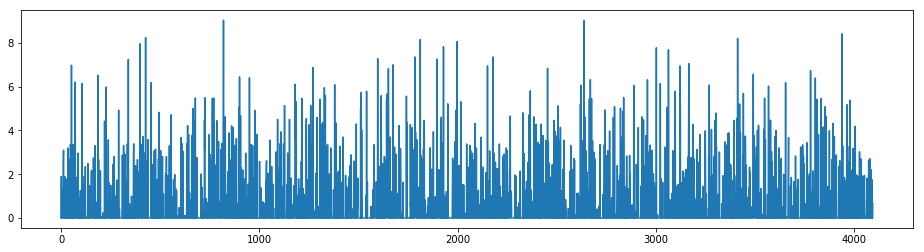

In [11]:
fv = feat_extractor.predict(x)
print(np.shape(fv))
plt.figure(figsize=(16,4))
plt.plot(fv[0])

Let's get all feature vectors:

In [13]:
fvs = []
for i in range(len(df_sel)):
    if i %10 == 0:
        print('extracting feature vector of image {0} of {1}'.format(i+1, len(df_sel)))
    img, x = load_image(image_path + df_sel['_id'].iloc[i] + '.jpg', target_size = model.input_shape[1:3])
    fv = feat_extractor.predict(x)[0]
    fvs.append(fv)
print('done')
fvs = np.array(fvs)

extracting feature vector of image 1 of 100
extracting feature vector of image 11 of 100
extracting feature vector of image 21 of 100
extracting feature vector of image 31 of 100
extracting feature vector of image 41 of 100
extracting feature vector of image 51 of 100
extracting feature vector of image 61 of 100
extracting feature vector of image 71 of 100
extracting feature vector of image 81 of 100
extracting feature vector of image 91 of 100
done


# Performing PCA

Now we perform PCA using the sklearn.decomposition.PCA function

In [14]:
from sklearn.decomposition import PCA

In [18]:
modelPCA = PCA(n_components=40)    #For PCA we only need 2 components but we will use this representation for t-SNE
XPCA = modelPCA.fit_transform(fvs)
print(np.shape(XPCA))
#print(XPCA)

(100, 40)


Visualisation using tools and code snipplets from https://github.com/ml4a/ml4a-guides/blob/master/notebooks/image-tsne.ipynb

100


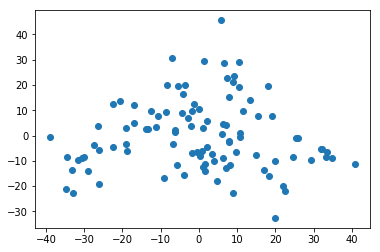

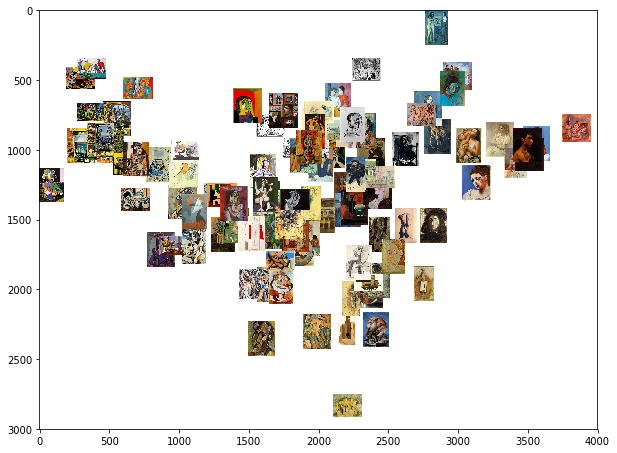

In [19]:
from PIL import Image
width = 4000
height = 3000
max_dim = 250
df_column = df_sel['_id']
plt.scatter(XPCA[:,0], XPCA[:,1])
#normalizing to interval between 0 and 1
XPCA_n = XPCA.copy()
XPCA_n[:,0] = (XPCA[:, 0] - np.min(XPCA[:, 0]))/(np.max(XPCA[:, 0]) - np.min(XPCA[:,0]))
XPCA_n[:,1] = (XPCA[:,1] - np.min(XPCA[:, 1]))/(np.max(XPCA[:, 1]) - np.min(XPCA[:,1]))
full_image = Image.new('RGBA', (width, height))
print(len(df_sel))
for i in range(len(df_sel)):
    tile = Image.open(image_path + df_column.iloc[i] + '.jpg')
    xt = XPCA_n[i,0]
    yt = XPCA_n[i,1]
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)))#, Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*xt), int((height-max_dim)*yt)), mask=tile.convert('RGBA'))
plt.figure(figsize = (10,10))
plt.imshow(full_image)
full_image.save('picasso_example500_PCA.png')

# Going to T-SNE

In [76]:
from sklearn.manifold import TSNE

In [89]:
myTSNE = TSNE(n_components = 2, early_exaggeration = 30, perplexity = 10, learning_rate = 100)
XTSNE = myTSNE.fit_transform(XPCA)
print(np.shape(XTSNE))

(500, 2)


500


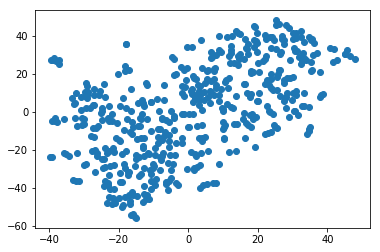

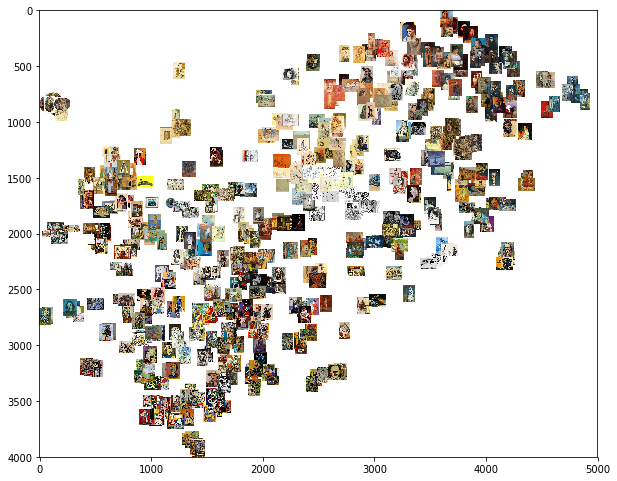

In [90]:
plt.scatter(XTSNE[:,0], -XTSNE[:,1])
width = 5000
height = 4000
max_dim = 150
#normalizing to interval between 0 and 1
XTSNE_n = XTSNE.copy()
XTSNE_n[:,0] = (XTSNE[:, 0] - np.min(XTSNE[:, 0]))/(np.max(XTSNE[:, 0]) - np.min(XTSNE[:,0]))
XTSNE_n[:,1] = (XTSNE[:, 1] - np.min(XTSNE[:, 1]))/(np.max(XTSNE[:, 1]) - np.min(XTSNE[:,1]))
full_image = Image.new('RGBA', (width, height))
print(len(df_sel))
for i in range(len(df_sel)):
    tile = Image.open(image_path + df_sel['_id'].iloc[i] + '.jpg')
    xt = XTSNE_n[i,0]
    yt = XTSNE_n[i,1]
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)))#, Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*xt), int((height-max_dim)*yt)), mask=tile.convert('RGBA'))
plt.figure(figsize = (10,10))
plt.imshow(full_image)
full_image.save('picasso_example500_TSNE.png')